In [290]:
# Import the required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas

In [291]:
# Read in Crypto Data
File = Path('../Dataset/crypto_df.csv')
crypto_df = pd.read_csv(File)


file2 = Path('../Dataset/btc_df.csv')
btc_df = pd.read_csv(file2)



file3 = Path('../datasets/btc_dataset_hourly.csv')
btc_tw_df = pd.read_csv(file3)
btc_tw_df


,time,nltk_polarity
0,2022-05-27 02:00:00+00:00,0.411728
1,2022-05-27 03:00:00+00:00,NaN
2,2022-05-27 04:00:00+00:00,0.185771
3,2022-05-27 05:00:00+00:00,0.432900
4,2022-05-27 06:00:00+00:00,NaN
...,...,...
137,2022-06-01 19:00:00+00:00,0.272658
138,2022-06-01 20:00:00+00:00,NaN
139,2022-06-01 21:00:00+00:00,0.156100
140,2022-06-01 22:00:00+00:00,0.312003


In [292]:
btc_df.head()

,date,open,close,low
0,2022-05-27 10:59:59.999,41102.29,40939.11,40918.78
1,2022-05-27 11:59:59.999,40956.02,40585.27,40497.27
2,2022-05-27 12:59:59.999,40583.16,40646.82,40433.17
3,2022-05-27 13:59:59.999,40643.60,40686.85,40618.18
4,2022-05-27 14:59:59.999,40688.24,40483.86,40463.15


In [293]:
from datetime import datetime, timedelta
now = datetime.now()

def hour_rounder(t):
    t = datetime.fromisoformat(t)
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

btc_df = btc_df.drop(columns=['open', 'low',])
btc_df = btc_df.reset_index().drop(columns=['index'])
btc_df['rounded_date'] = btc_df['date'].apply(lambda t: hour_rounder(t))
btc_df = btc_df.drop(columns='date')

btc_df.head()


,close,rounded_date
0,40939.11,2022-05-27 11:00:00
1,40585.27,2022-05-27 12:00:00
2,40646.82,2022-05-27 13:00:00
3,40686.85,2022-05-27 14:00:00
4,40483.86,2022-05-27 15:00:00


In [294]:
btc_df['polarity'] = np.random.randint(2, size=121)
btc_df = btc_df.reset_index()
btc_df = btc_df.set_index('rounded_date')
btc_df = btc_df.drop(columns='index')



In [295]:
# Calculate the hourly returns using the closing prices and the pct_change function
btc_df["actual_returns"] = btc_df["close"].pct_change()
btc_df = btc_df.dropna()
btc_df.head()


,close,polarity,actual_returns
rounded_date,,,
2022-05-27 12:00:00,40585.27,1,-0.008643
2022-05-27 13:00:00,40646.82,1,0.001517
2022-05-27 14:00:00,40686.85,1,0.000985
2022-05-27 15:00:00,40483.86,0,-0.004989
2022-05-27 16:00:00,40366.24,1,-0.002905


In [296]:
# Define a window size of 50 & 100
short_window = 50
long_window = 100

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
btc_df["sma_50"] = btc_df["close"].rolling(window=short_window).mean()
btc_df["sma_100"] = btc_df["close"].rolling(window=long_window).mean()
btc_df = btc_df.dropna()

# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = btc_df[["sma_50", "sma_100", 'polarity']].copy()
# Display sample data
display(X.head())
display(X.tail())

,sma_50,sma_100,polarity
rounded_date,,,
2022-05-31 15:00:00,42000.3468,41198.2162,0
2022-05-31 16:00:00,42070.9810,41232.5033,1
2022-05-31 17:00:00,42140.0708,41264.5754,0
2022-05-31 18:00:00,42207.7024,41297.0134,1
2022-05-31 19:00:00,42276.0212,41331.5796,1


,sma_50,sma_100,polarity
rounded_date,,,
2022-06-01 07:00:00,43094.7032,41774.1493,0
2022-06-01 08:00:00,43164.8026,41818.6019,1
2022-06-01 09:00:00,43237.1248,41864.7240,0
2022-06-01 10:00:00,43305.1372,41903.8806,1
2022-06-01 11:00:00,43370.6334,41945.8684,0


In [297]:
# Create a new column in the btc_df called signal setting its value to zero.
btc_df["Signal"] = 0.0

# Create the signal to buy
btc_df.loc[(btc_df["actual_returns"] >= 0) & (btc_df['polarity'] == 1), "Signal"] = 1

# Create the signal to sell
btc_df.loc[(btc_df["actual_returns"] < 0) & (btc_df['polarity'] == 0), "Signal"] = -1


y = btc_df["Signal"].copy()



In [298]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)

In [299]:
# Imports
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [300]:
# Imports SVM Machine Learning Model
from sklearn import svm
from sklearn.metrics import classification_report

In [301]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1.,  0.,  0., -1., -1., -1.,  0.,  1.,  1.,  1.])

In [302]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         4
         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [303]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [304]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         2
         0.0       1.00      0.50      0.67         4
         1.0       0.33      1.00      0.50         1

    accuracy                           0.71         7
   macro avg       0.78      0.83      0.72         7
weighted avg       0.90      0.71      0.74         7



In [305]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [306]:
# Run ML Model 1 - Logisitic Regression
model_1 = LogisticRegression()
model_1.fit(X_train_scaled, y_train)
ypred_lr = model_1.predict(X_test_scaled)

In [307]:
# Run ML Model 2 - Gaussian NB
model_2 = GaussianNB()
model_2.fit(X_train_scaled, y_train)
ypred_GNB = model_2.predict(X_test_scaled)

In [308]:
# Run ML Model 3 - Random Forest Classifier
model_3 = RandomForestClassifier()
model_3.fit(X_train_scaled, y_train)
ypred_RFC = model_3.predict(X_test_scaled)

In [309]:
eclf = VotingClassifier(
 estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],
 voting='hard'
)
eclf.fit(X_train_scaled,y_train)
ypred_vc = eclf.predict(X_test_scaled)


for clf, label in zip([svm_model, model_1, model_2, model_3, eclf], ['Support Vector', 'Logistic Regression', 'Naive Bayes', 'Random Forest', 'Ensemble']):
 scores = cross_val_score(clf, X, y, scoring='accuracy', cv=4)
 print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.43 (+/- 0.10) [Support Vector]
Accuracy: 0.48 (+/- 0.12) [Logistic Regression]
Accuracy: 0.77 (+/- 0.15) [Naive Bayes]
Accuracy: 0.87 (+/- 0.14) [Random Forest]
Accuracy: 0.87 (+/- 0.14) [Ensemble]


In [310]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["Predict_SVM"] = testing_signal_predictions
predictions_df["Predict_LR"] = ypred_lr
predictions_df["Predict_NB"] = ypred_GNB
predictions_df["Predict_RF"] = ypred_RFC
predictions_df["Predict_VC"] = ypred_vc
predictions_df["actual_returns"] = btc_df["actual_returns"]
predictions_df["SVM_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_SVM"]
predictions_df["GNB_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_NB"]
predictions_df["RFC_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_RF"]
predictions_df["VC_Predictions"] = predictions_df["actual_returns"] * predictions_df["Predict_VC"]

predictions_df.tail()

,Predict_SVM,Predict_LR,Predict_NB,Predict_RF,Predict_VC,actual_returns,SVM_Predictions,GNB_Predictions,RFC_Predictions,VC_Predictions
rounded_date,,,,,,,,,,
2022-06-01 06:00:00,0.0,1.0,1.0,-1.0,1.0,-0.000620,-0.000000,-0.000620,0.000620,-0.000620
2022-05-31 16:00:00,1.0,1.0,1.0,1.0,1.0,-0.001459,-0.001459,-0.001459,-0.001459,-0.001459
2022-05-31 23:00:00,1.0,1.0,1.0,1.0,1.0,-0.002876,-0.002876,-0.002876,-0.002876,-0.002876
2022-05-31 20:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-0.000920,0.000920,0.000920,0.000920,0.000920
2022-06-01 02:00:00,1.0,1.0,1.0,1.0,1.0,0.010168,0.010168,0.010168,0.010168,0.010168


<AxesSubplot:xlabel='rounded_date'>

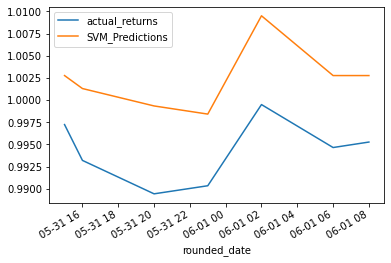

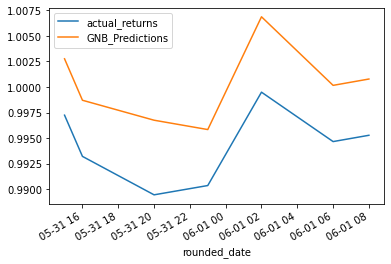

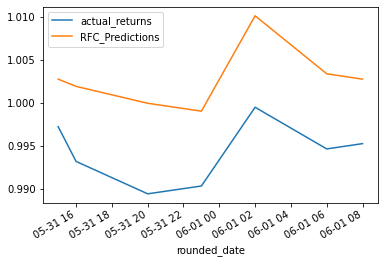

In [311]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "SVM_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "GNB_Predictions"]]).cumprod().plot()
(1 + predictions_df[["actual_returns", "RFC_Predictions"]]).cumprod().plot()

In [312]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
btc_df["Entry/Exit"] = btc_df["Signal"].diff()

In [313]:
# Initialize trade_type column for buys and sells
btc_df['trade_type'] = np.nan

# Initialize variable to hold the previous_price
previous_price = 0


# Loop through the Pandas DataFrame and code the conditions of the trading strategy 
for index, row in btc_df.iterrows():
    
    # buy if the previous price is 0 and Twitter Sentiment has Positive for 7 consecutive days.
    if previous_price == 0:
        btc_df.loc[index, "trade_type"] = "buy"

    # buy if the current day price is less than the previous day price and Twitter Sentiment has Positive for 4 consecutive days
    elif row["close"] < previous_price and row['polarity'] == 1:
        btc_df.loc[index, "trade_type"] = "buy"

    # sell if the current day price is greater than the previous day price and Twitter Sentiment has Negative for 3 consecutive days
    elif row["close"] > previous_price and row['polarity'] == 0:
        btc_df.loc[index, "trade_type"] = "sell"

    # else hold if the current day price is equal to the previous day price and Twitter Sentiment is Neutrual or Greater in 4 days
    else:
        btc_df.loc[index, "trade_type"] = "hold"
    
    # reset the previous_price variable to the close price of the current row
    previous_price = row["close"]

    # if the index is the last index of the Dataframe, set the trade_type to sell
    if index == btc_df.index[-1]:
        btc_df.loc[index, "trade_type"] = "sell"


btc_df.head()

,close,polarity,actual_returns,sma_50,sma_100,Signal,Entry/Exit,trade_type
rounded_date,,,,,,,,
2022-05-31 15:00:00,44078.31,0,-0.002762,42000.3468,41198.2162,-1.0,NaN,buy
2022-05-31 16:00:00,44013.98,1,-0.001459,42070.9810,41232.5033,0.0,1.0,buy
2022-05-31 17:00:00,43854.03,0,-0.003634,42140.0708,41264.5754,-1.0,-1.0,hold
2022-05-31 18:00:00,43930.65,1,0.001747,42207.7024,41297.0134,1.0,2.0,hold
2022-05-31 19:00:00,43940.48,1,0.000224,42276.0212,41331.5796,1.0,0.0,hold


In [314]:
plot_df = btc_df.reset_index()

# Create a Sell Plot
sell = plot_df[plot_df["trade_type"] == "sell"]["close"].hvplot.scatter(
    color="red",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Buy Plot
buy = plot_df[plot_df["trade_type"] == "buy"]["close"].hvplot.scatter(
    color="green",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400)

# Create a Hold Plot
neu = plot_df[plot_df["trade_type"] == "hold"]["close"].hvplot.scatter(
    color="orange",
    marker="v",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400) 

security_close = plot_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)    

# Create the overlay plot
buy_sell_plot = buy * sell * neu * security_close

# Show the plot
buy_sell_plot.opts(
    title="Bitcoin - Buy, Sell and Hold Chart"
)     

:Overlay
   .Scatter.Close.I   :Scatter   [index]   (close)
   .Scatter.Close.II  :Scatter   [index]   (close)
   .Scatter.Close.III :Scatter   [index]   (close)
   .Curve.I           :Curve   [index]   (close)